# Laboratory #3_1 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from skimage import data, io
import os
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

In [ ]:
HussPath = '/content/drive/MyDrive/MAI/CV/Lab 4/images/'
ArmandoPath = '/content/drive/MyDrive/UNIVERSITAT/Master/1-1/CV/LabsCV/3_1/images/'

# Use the path where your images folder is located
path = ArmandoPath

In [ ]:
# Auxiliar handcrafted function to plot n images easily
def plot_images(images, size=(10,10), width=0, height=0, limits=[], titles=[], rectangles=[]):
  assert len(images) == len(limits) or limits == [], "Define a number of limits according to the number of images"
  if not width : width  = len(images)
  if not height: height = 1
  fig, axs = plt.subplots(height,width,figsize=size)
  for idx,image in enumerate(images):
    if width != 1 and height != 1:
      axs = axs.flatten()
    ax = axs if width == 1 and height == 1 else axs[idx]
    lim = limits[idx] if limits != [] else (None,None)
    title = titles[idx] if titles != [] else None
    ax.imshow(image, cmap='gray', vmin = lim[0], vmax = lim[1])
    if rectangles and idx < len(rectangles):
      (bestY, bestX), width, heigth, color = rectangles[idx]
      rect = patches.Rectangle((bestY, bestX), width, heigth, linewidth=1, edgecolor=color, facecolor='none')
      ax.add_patch(rect)
    ax.set_title(title)
    ax.set_xticks([]); 
    ax.set_yticks([])
  plt.show()

# Face Detection using AdaBoost

### Exercise #1

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [ ]:
def compute_integral_image(img_arr, our=False):
    """
    Calculates the integral image based on the original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    if our:
      for i, row in enumerate(img_arr):
        for j, col in enumerate(row):
          up = integral_image_arr[i+1][j]
          diag = integral_image_arr[i][j]
          left = integral_image_arr[i][j+1]
          value = img_arr[i,j]

          integral_image_arr[i+1][j+1] = value+left+up-diag
    else:
      integral_image_arr_small = np.cumsum(np.cumsum(img_arr, axis=0), axis=1);
      integral_image_arr[1:,1:] = integral_image_arr_small

    return integral_image_arr

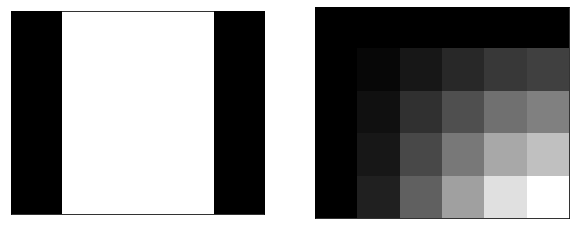

Original image:
[[1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]]
Integral image:
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


In [ ]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
ii_img_array = compute_integral_image(img_array, our=False)
plot_images([img_array,ii_img_array])
print("Original image:")
print(img_array)
print("Integral image:")
print(ii_img_array)

*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

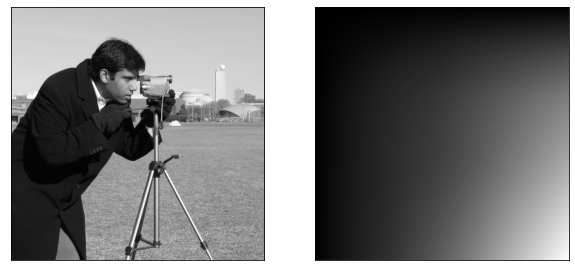

In [ ]:
camera_image = data.camera()
camera_integral_image = compute_integral_image(camera_image, our=False)
plot_images([camera_image,camera_integral_image])

### Exercise #2

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [ ]:
# Use the properties of the integral image to compute the sum_region function
def sum_region(integral_img_arr, top_left, bottom_right):
  top_right   = [top_left[0], bottom_right[1]]
  bottom_left = [bottom_right[0], top_left[1]]

  sum_top_left     = integral_img_arr[top_left[0],top_left[1]]
  sum_top_right    = integral_img_arr[top_right[0],top_right[1]]
  sum_bottom_left  = integral_img_arr[bottom_left[0],bottom_left[1]]
  sum_bottom_right = integral_img_arr[bottom_right[0],bottom_right[1]]

  return sum_top_left+sum_bottom_right-(sum_top_right+sum_bottom_left)

*   Make the following tests:

In [ ]:
# result you should get (12)
print(sum_region(ii_img_array, [1, 1], [3, 4]))

12.0


In [ ]:
# result you should get (32)
print(sum_region(ii_img_array, [0, 0], [-1, -1]))

32.0


### Exercise #3

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [ ]:
def load_integral_images(path):
    ii_images = []
    for _file in os.listdir(path):
        
        if not _file.endswith(".png"):
          print("Error with",_file)
          continue
      
        #### Read image
        image = io.imread(path+_file, as_gray=True)

        #### Compute integral image
        image_integral = compute_integral_image(image, our=False)

        #### Remember to scale the images (with the max pixel intensity value)
        image_integral /= np.max(image_integral)
        
        ii_images.append(image_integral)

    return ii_images

# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

*   Use the load_integral_images function to compute the integral images of training and testing data

In [ ]:
pos_training_path = os.path.join(path, 'train_data/faces/')
neg_training_path = os.path.join(path, 'train_data/non_faces/')
pos_testing_path  = os.path.join(path, 'test_data/faces/')
neg_testing_path  = os.path.join(path, 'test_data/non_faces/')

In [ ]:
pos_training = load_integral_images(pos_training_path)
neg_training = load_integral_images(neg_training_path)
pos_testing = load_integral_images(pos_testing_path)
neg_testing = load_integral_images(neg_testing_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


*   Visualize a few original images and the corresponding integral images using matplotlib.

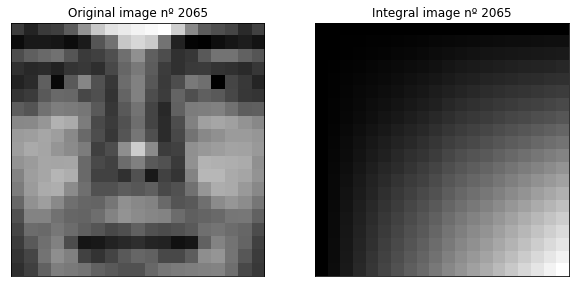

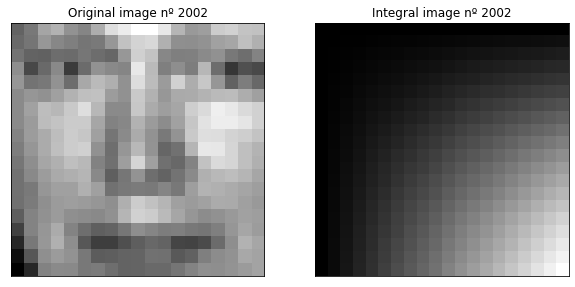

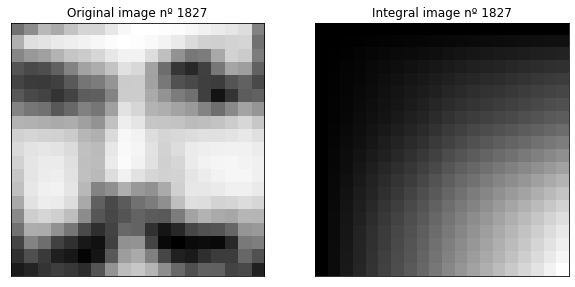

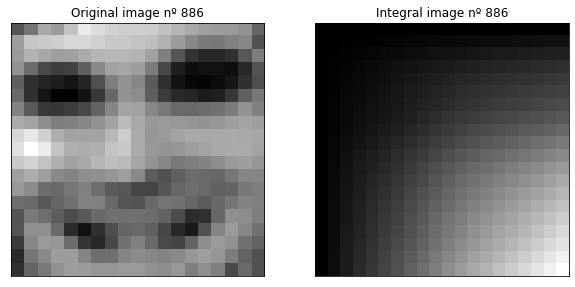

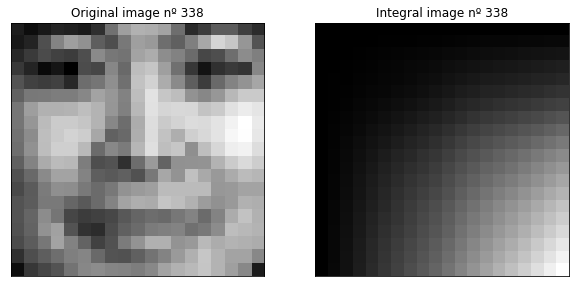

In [ ]:
posTrainFiles = os.listdir(pos_training_path)
indexs = np.random.randint(0,len(posTrainFiles)-1,5)
for idx in indexs:
  image = io.imread(pos_training_path+posTrainFiles[idx], as_gray=True)
  image_integral = pos_training[idx]
  plot_images([image,image_integral],titles=[f"Original image nº {idx}",f"Integral image nº {idx}"])

We can see some faces and their respective integral image.

### Exercise #4

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [ ]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [ ]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [ ]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.

                for x in range(img_height-feature_height-1):
                    for y in range(img_width-feature_width-1):
                      # Add both polarities to obtain more features where to choose the more representative ones
                      # Used threshold == 0 in order to vote correctly (score positive => 1, score negative => 0)
                      harr_featurePos = HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0,  1)
                      features.append(harr_featurePos)
                      harr_featureNeg = HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, -1)
                      features.append(harr_featureNeg)

    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Haar-like features:', time.time()-t0)
    return features

### Exercise #5

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [ ]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time 
classifiers = learn(pos_training, neg_training, num_classifiers=num_classifiers, 
                    min_feature_width=min_feature_width, max_feature_width=max_feature_width, 
                    min_feature_height=min_feature_height, max_feature_height=max_feature_height)

Creating Haar-like features..
	2090 features created.
	Time needed for calculating Haar-like features: 0.003659963607788086
Calculating scores for images..
	Time needed for calculating scores: 276.2909460067749
Selecting classifiers..
	Time needed for Selecting Classifiers: 35.34346580505371 

CPU times: user 2min, sys: 7.66 s, total: 2min 7s
Wall time: 5min 11s


### Exercise #6

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [ ]:
import math
# Count till we found a majority of positive votes
def ensemble_vote(int_img, classifiers):
  majorityThreshold = math.floor(len(classifiers)/2+1)
  for classifier in classifiers:
    majorityThreshold -= (classifier.get_vote(int_img) > 0)
    if majorityThreshold == 0: return 1
  return 0

def ensemble_vote_all(int_imgs, classifiers):
  votes = []
  for int_img in int_imgs:
    vote = ensemble_vote(int_img, classifiers)
    votes.append(vote)
  return np.array(votes)

In [ ]:
pos_training_votes = ensemble_vote_all(pos_training, classifiers)
neg_training_votes = ensemble_vote_all(neg_training, classifiers)
pos_testing_votes  = ensemble_vote_all( pos_testing, classifiers)
neg_testing_votes  = ensemble_vote_all( neg_testing, classifiers)

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [ ]:
def show_results(pos_training_votes, neg_training_votes, pos_testing_votes, neg_testing_votes, roundValue=4, returnPercentages=False):
  total_pos_train = len(pos_training_votes)
  correct_pos_train = np.sum(pos_training_votes)
  perc_correct_pos_train = round(100*correct_pos_train/total_pos_train, roundValue)

  total_neg_train = len(neg_training_votes)
  incorrect_neg_train = np.sum(neg_training_votes)
  correct_neg_train = total_neg_train-incorrect_neg_train
  perc_correct_neg_train = round(100*correct_neg_train/total_neg_train, roundValue)

  total_pos_test = len(pos_testing_votes)
  correct_pos_test = np.sum(pos_testing_votes)
  perc_correct_pos_test = round(100*correct_pos_test/total_pos_test, roundValue)

  total_neg_test = len(neg_testing_votes)
  incorrect_neg_test = np.sum(neg_testing_votes)
  correct_neg_test = total_neg_test-incorrect_neg_test
  perc_correct_neg_test = round(100*correct_neg_test/total_neg_test, roundValue)

  print("train results:")
  print(f"Correctly identified Faces: {correct_pos_train}/{total_pos_train} ({perc_correct_pos_train}%)")
  print(f"Correctly identified non-Faces: {correct_neg_train}/{total_neg_train} ({perc_correct_neg_train}%)")
  print()
  print("train results:")
  print(f"Correctly identified Faces: {correct_pos_test}/{total_pos_test} ({perc_correct_pos_test}%)")
  print(f"Correctly identified non-Faces: {correct_neg_test}/{total_neg_test} ({perc_correct_neg_test}%)")

  if returnPercentages:
    return perc_correct_pos_train, perc_correct_neg_train, perc_correct_pos_test, perc_correct_neg_test

In [ ]:
show_results(pos_training_votes, neg_training_votes, 
             pos_testing_votes, neg_testing_votes)

train results:
Correctly identified Faces: 2069/2429 (85.1791%)
Correctly identified non-Faces: 6139/8555 (71.7592%)

train results:
Correctly identified Faces: 254/472 (53.8136%)
Correctly identified non-Faces: 97/128 (75.7812%)


We can see that the results using only two classifiers are quite good obtaining test accuracies of around 54% for the detection of faces and 76% for the detection of non-faces.

### Exercise #7

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers.
*   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time 
classifiers_20 = learn(pos_training, neg_training, num_classifiers=num_classifiers, 
                       min_feature_width=min_feature_width, max_feature_width=max_feature_width, 
                       min_feature_height=min_feature_height, max_feature_height=max_feature_height)

Creating Haar-like features..
	2090 features created.
	Time needed for calculating Haar-like features: 0.010715961456298828
Calculating scores for images..
	Time needed for calculating scores: 279.41870379447937
Selecting classifiers..
	Time needed for Selecting Classifiers: 360.9275951385498 

CPU times: user 7min 22s, sys: 9.4 s, total: 7min 32s
Wall time: 10min 40s


In [ ]:
pos_training_votes_20 = ensemble_vote_all(pos_training, classifiers_20)
neg_training_votes_20 = ensemble_vote_all(neg_training, classifiers_20)
pos_testing_votes_20 = ensemble_vote_all(pos_testing, classifiers_20)
neg_testing_votes_20 = ensemble_vote_all(neg_testing, classifiers_20)

In [ ]:
show_results(pos_training_votes_20, neg_training_votes_20, 
             pos_testing_votes_20, neg_testing_votes_20)

train results:
Correctly identified Faces: 1902/2429 (78.3038%)
Correctly identified non-Faces: 7754/8555 (90.6371%)

train results:
Correctly identified Faces: 186/472 (39.4068%)
Correctly identified non-Faces: 117/128 (91.4062%)


*   **Discuss if the classification results improved in the train data.**

> With 2 and 20 classifiers, we obtain a significant difference in the training dataset, taking into account the accuracy of faces and non-faces. For only 2 classifiers, we obtain 85% accuracy in identifying faces, while with 20 classifiers, we only obtain 78%. However, considering the non-faces, with 2 classifiers we obtain a poor 71%, while we obtain a great 90% from the non-faces. \
It is noticeable how two classifiers are doing a better job of identifying faces while 20 classifiers are doing a better job of identifying non-faces. We can see the same effects in the test set. This could be caused by the fact that it is much harder to have half of the 20 classifiers (10 classifiers) agree on the same positive decision than it is to have only one do so, which is the case when using two classifiers. Furthermore, this could be considered overfitting or may be caused by the disbalance of the training classes (2429 faces vs. 8555 non-faces).

### Exercise #8

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [ ]:
# Add all the votes and see if they can surpass the threshold or not
def ensemble_vote_t(int_img, classifiers, threshold):
  votes = 0
  for classifier in classifiers:
    votes += classifier.get_vote(int_img)
  
  return int(votes > threshold)

def ensemble_vote_all_t(int_imgs, classifiers, threshold):
  votes = []
  for int_img in int_imgs:
    vote = ensemble_vote_t(int_img, classifiers, threshold)
    votes.append(vote)
  return np.array(votes)

*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

We decided to take thresholds untill +0.5 for making the comparison more centralized at 0 (the point of interest).

In [ ]:
thresholds = np.array([x for x in range(-5,6,1)])/10
correct_pos_trains = []
correct_neg_trains = []
correct_pos_tests = []
correct_neg_tests = []
for threshold in thresholds:
  print("Treshold",threshold)
  print("--------------------------------------------------------------------")
  pos_training_votes_20 = ensemble_vote_all_t(pos_training, classifiers_20, threshold)
  neg_training_votes_20 = ensemble_vote_all_t(neg_training, classifiers_20, threshold)
  pos_testing_votes_20 = ensemble_vote_all_t(pos_testing, classifiers_20, threshold)
  neg_testing_votes_20 = ensemble_vote_all_t(neg_testing, classifiers_20, threshold)
  correct_pos_train, correct_neg_train, correct_pos_test, correct_neg_test = show_results(pos_training_votes_20, neg_training_votes_20, pos_testing_votes_20, neg_testing_votes_20, returnPercentages=True)
  print("--------------------------------------------------------------------\n")
  correct_pos_trains.append(correct_pos_train)
  correct_neg_trains.append(correct_neg_train)
  correct_pos_tests.append(correct_pos_test)
  correct_neg_tests.append(correct_neg_test)

Treshold -0.5
--------------------------------------------------------------------
train results:
Correctly identified Faces: 2356/2429 (96.9946%)
Correctly identified non-Faces: 5955/8555 (69.6084%)

train results:
Correctly identified Faces: 345/472 (73.0932%)
Correctly identified non-Faces: 90/128 (70.3125%)
--------------------------------------------------------------------

Treshold -0.4
--------------------------------------------------------------------
train results:
Correctly identified Faces: 2317/2429 (95.389%)
Correctly identified non-Faces: 6268/8555 (73.2671%)

train results:
Correctly identified Faces: 328/472 (69.4915%)
Correctly identified non-Faces: 94/128 (73.4375%)
--------------------------------------------------------------------

Treshold -0.3
--------------------------------------------------------------------
train results:
Correctly identified Faces: 2307/2429 (94.9774%)
Correctly identified non-Faces: 6496/8555 (75.9322%)

train results:
Correctly identifie

*   Make a bar plot for 1-4. In the x axis write the threshold value.

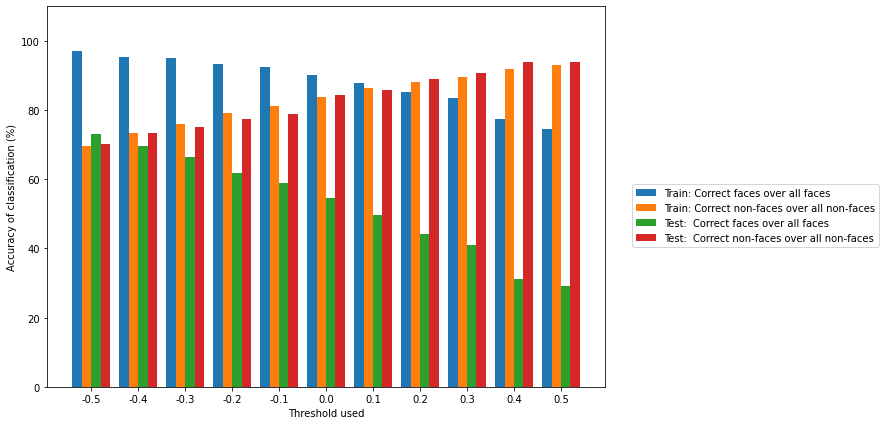

In [ ]:
fig, axs = plt.subplots(figsize=(10,7))

width = 0.02
plt.bar(thresholds, correct_pos_trains, width, label="Train: Correct faces over all faces")
plt.bar(thresholds+width, correct_neg_trains, width, label="Train: Correct non-faces over all non-faces")
plt.bar(thresholds+width*2, correct_pos_tests, width, label="Test:  Correct faces over all faces")
plt.bar(thresholds+width*3, correct_neg_tests, width, label="Test:  Correct non-faces over all non-faces")

plt.ylim(0,110)
plt.xlabel("Threshold used")
plt.ylabel("Accuracy of classification (%)")
plt.xticks(thresholds+width+width/2,thresholds)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.2, 0.5, 0.5))
plt.show()

*   **Discuss what happens when you increase the threshold value.**

> We can notice in a general way how the accuracy of the faces classification decreases if we increase the threshold value, while the accuracy of the non-faces classification increases. This can be seen in the training as well as the test dataset.\
We could interpret this threshold as a value to control a bit the accuracy of the model by deciding what is more important: having fewer false negatives or false positives. In a real application, this can be really useful. \
As a conclusion, answering the question, if we increase the threshold value, we obtain a model that classifies almost perfectly the non-faces but has poor testing accuracy on faces classification. The other way around, if we decrease the threshold value, we obtain a model that is more capable of detecting faces while having progressively worse results in the non-faces classification.

# Face Recognition using PCA


In [ ]:
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

*   Loading the dataset

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, height, width = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


*   Creating training and testing set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Number of classes in Train set:', np.unique(y_train).shape[0])

Train data shape: (966, 1850)
Test data shape: (322, 1850)
Number of classes in Train set: 7


### Exercise #1: PCA Computation
*   Compute a PCA (eigenfaces) on the face dataset
    *   *Set* number of components to 100

In [ ]:
components = 100
pca = PCA(n_components=components)
pca.fit(X_train)

PCA(n_components=100)

*   Reshape the components output of pca to obtain the eigen faces

In [ ]:
eigen_faces = pca.components_.reshape((components, height, width))
eigen_faces.shape

(100, 50, 37)

*   Project the training and testing faces data on the orthonormal basis

In [ ]:
X_train_orth = pca.transform(X_train)
X_test_orth  = pca.transform(X_test)

*   Plot the most significative eigenfaces (Show the top 12 eigenfaces) as a matplotlib

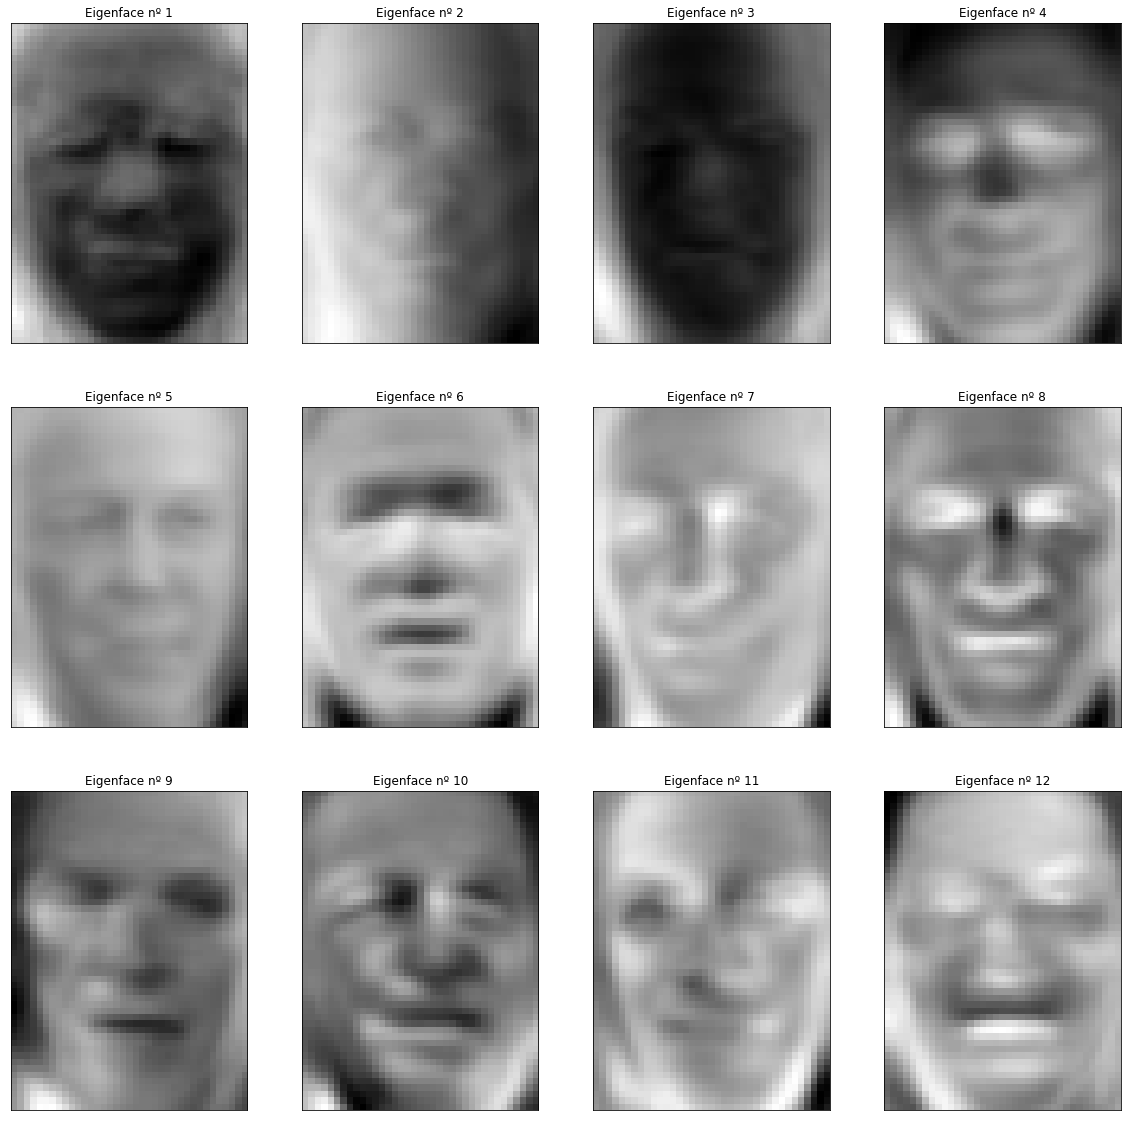

In [ ]:
eigenfaces_to_plot = []
eigenfaces_names = []
for i in range(12):
  eigenfaces_to_plot.append(eigen_faces[i])
  eigenfaces_names.append(f"Eigenface nº {i+1}")

plot_images(eigenfaces_to_plot, titles=eigenfaces_names, size=(20,20), height=3, width=4)

*   Show the total percentage of variance explained by the selected components of the PCA.


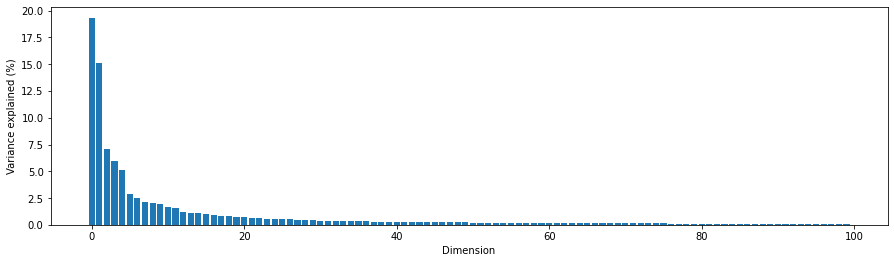

Total percentage of variance explained with 100 components: 92.8346% 


In [ ]:
variance_percentages = pca.explained_variance_ratio_
fig, axs = plt.subplots(figsize=(15,4))
plt.bar(range(len(variance_percentages)),variance_percentages*100)
plt.xlabel("Dimension"); plt.ylabel("Variance explained (%)")
plt.show()

total = round(np.sum(variance_percentages)*100,4)
print(f"Total percentage of variance explained with {components} components: {total}% ")

*   **What are the shortcomings of PCA?**

> The PCA has several shortcomings. First of all, in very mixed data, PCA is not enough to perform face recognition. So, PCA tends to perform better if we have clearly separated data. Moreover, PCA doesn't pay attention to the underlying class structure. So, it is more difficult to discriminate between classes. Due to this, we have other algorithms, such as LDA, that solve these issues. Finally, we would like to mention that using ICA may improve the classification because it does not require them to be orthogonal between each other.

### Exercise #2: k-NN Classification


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


*   Train a k-nearest neighbor model with the eigenfaces using the default parameters

In [ ]:
neigh = KNeighborsClassifier()
neigh.fit(X_train_orth, y_train)

KNeighborsClassifier()

*   Predict the test data using the trained classifier

In [ ]:
y_predict = neigh.predict(X_test_orth)

### Exercise #3: Quantitative results


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


*   Compute accuracy, classification report and confusion matrix of the trained classifier

In [ ]:
# Accuracy
correct_y = len(y_test)-len(np.nonzero(y_predict-y_test)[0])
accuracy = accuracy_score(y_test, y_predict)*100

# Classification report
class_report = classification_report(y_test, y_predict)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, normalize='true')

Classified 187 out of 322 => Accuracy: 58.07453416149069%
Classification report:
              precision    recall  f1-score   support

           0       0.31      0.31      0.31        13
           1       0.52      0.60      0.56        60
           2       0.42      0.41      0.42        27
           3       0.66      0.79      0.72       146
           4       0.42      0.20      0.27        25
           5       0.55      0.40      0.46        15
           6       0.56      0.25      0.35        36

    accuracy                           0.58       322
   macro avg       0.49      0.42      0.44       322
weighted avg       0.57      0.58      0.56       322

Confussion matrix:


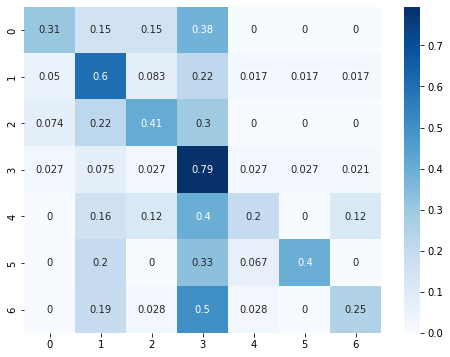

In [ ]:
print(f"Classified {correct_y} out of {len(y_test)} => Accuracy: {accuracy}%")
print("Classification report:")
print(class_report)
print("Confussion matrix:")
fig, axs = plt.subplots(figsize=(8,6))
sns.heatmap(conf_matrix, vmin=0, cmap='Blues', annot=True)
plt.show()

*   **Explain the measures showed in the classification report.**
> The classification report allows a better understanding of the overall performance of our model. It shows the precision, recall, f1-score, and support metrics according to each class that the model attempts to predict. The f1-score metric is computed using the  precision and recall metrics. The support metric is the number of actual occurrences of the class in the set of data.  In the classification report, it can be seen how the different classes are described using the metrics mentioned above.\
Furthermore, in the last 3 lines of the report, we have general metrics about the model. The first metric we have is accuracy. We can only see that we have the third column. This is because the accuracy metric does not use the metrics of precision and recall.\
Next, in the second line, we have the macro average of the 3 metrics (precision, recall, and f1-score). This metric is important since it is very useful on unbalanced datasets. With the macro average method, we treat all classes in the same way. With this, we get a better understanding of the model, something that we do not get with accuracy.\
Finally, we have the weighted average. This method considers the weight of each class according to its proportion in the total number of individuals. Therefore, this type of average may not perform very well on unbalanced datasets.
*   **Discuss the obtained classification results, both the quantitative as well as the qualitative results.**
> In this particular example, we can see that there are two classes (1, 3) that have a better f1-score than all the other classes. However, this is due to the elevated number of samples (support metric) in the data. Due to this, the KNN model is confusing because most of the neighbors are similar, making it more difficult to classify. \
If we check the last three rows of the classification report, we can see that accuracy and weighted behave behave in a similar way. We can appreciate that we obtain 0.58 in the accuracy metric and 0.56 in the weighted f1-score metric. If we focus on the macro average of the f1-score, we can clearly conclude that the performance of our model is worse than it seems. Due to the fact that our dataset is unbalanced, we should consider this metric as the real indicator of performance.\
If we look at the qualitative results, we can appreciate that the model has problems classifying **other classes** than 1 and 3. We can see in the confusion matrix that the majority of the classes are being confused with these classes. The reason is the same as what we mentioned before. We can see that the KNN model doesn't perform well in imbalanced datasets. Hence, first we should try to balance the data.

### Exercise #4

*   **How is the optimal value of 'k' found?**

> In order to choose the optimal values of k, we need to try different values of k with the same dataset. So, we should do a grid search with cross-validation. This grid search will look over all the k values we have passed as parameters and choose the one that has obtained the best results doing cross validation. It is important to note that we should always do cross-validation because we get more stable results. Once we have done the grid search, we will choose the optimal k as the one that has the highest score.

*   Use GridSearch to find the optimal value of 'k'.
    *   *Hint: GridSearchCV is available in sklearn.model_selection*


In [ ]:
params = {'n_neighbors': [x for x in range(1,101,1)]}

knn = KNeighborsClassifier(n_jobs=-1)
gknn = GridSearchCV(knn, params, cv=20, n_jobs=-1,verbose=True)
gknn.fit(X_train, y_train)
score = round(gknn.score(X_test, y_test)*100,4)

print(f"The best score (accuracy) obtained is {score} using {gknn.best_params_['n_neighbors']} neighbors")

Fitting 20 folds for each of 100 candidates, totalling 2000 fits
The best score (accuracy) obtained is 60.559 using 8 neighbors


*   What is the accuracy of the best estimator?

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred)*100,4)
print(f"The accuracy using {gknn.best_params_['n_neighbors']} neighbors is {accuracy}%")

The accuracy using 8 neighbors is 60.559%


### Exercise #5: Qualitative evaluation

*   Plot some of the prediction images using matplotlib subplots (4 x 4). Show the true label and predicted label as the title of each sub plot.

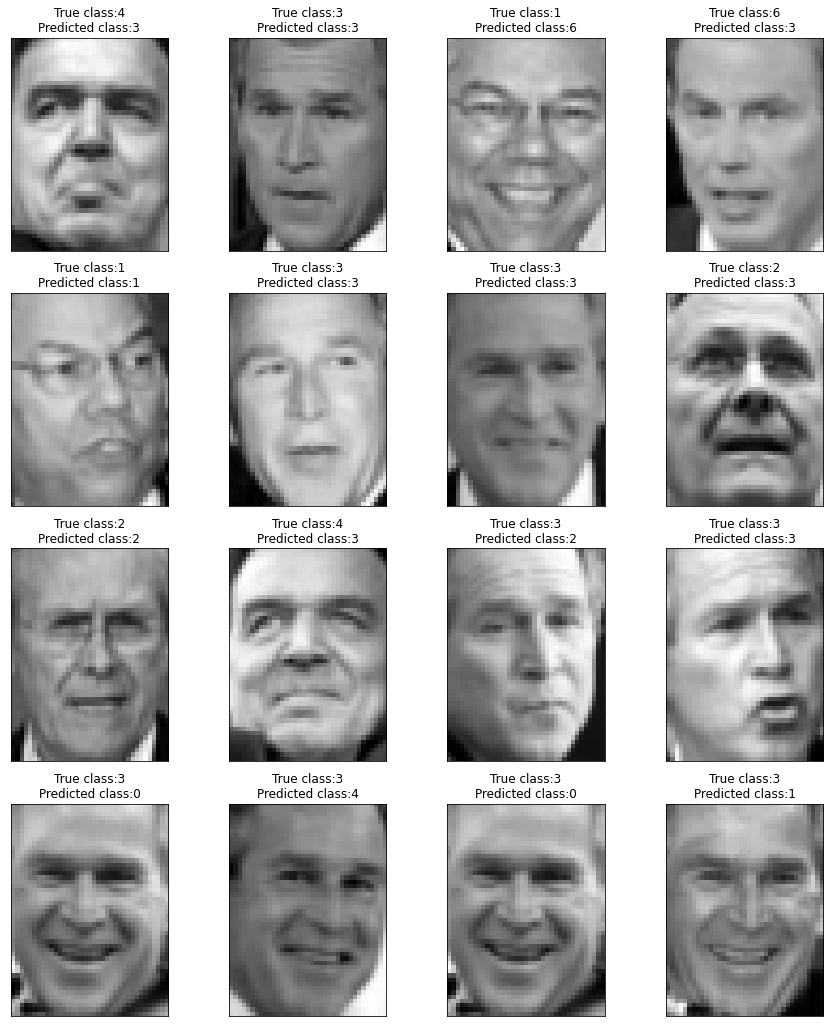

In [ ]:
images, titles = [], []
indexs = np.random.randint(0,len(X_test)-1,16)
for idx in indexs:
  images.append(X_test[idx].reshape(height, width))
  titles.append(f"True class:{y_test[idx]}\nPredicted class:{y_pred[idx]}")

plot_images(images, height=4, width=4, titles=titles, size=(15,18))

*   **What are the disadvantages of using kNN?**

> There are several disadvantages to using KNN. First of all, the accuracy of the model depends on the quality of the data. As a clear example of this, as we have seen before, unbalanced datasets don't give us acceptable results. So, before applying the kNN model, we should analyze our dataset and try to improve its quality. \
Moreover, with large datasets and a large number of neighbors, the prediction stage might be slow because we have to compute the k nearest neighbors over the entire dataset. So, with large datasets, the performance of the model becomes slower. \
Finally, we would like to mention that kNN is sensitive to the scale of the data and has irrelevant features. So, before applying kNN, we should always scale our data and reduce dimensionality.


---

# **End of L3_1: Face Detection and Recognition**
Deadline for L3_1 submission in CampusVirtual is: **Thursday, the 10th of November, 2022**